In [102]:
import os
from pathlib import Path
from typing import Callable, Optional, Union, List
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import arviz as az

import jax.numpy as jnp
from jax import random
from jax import nn
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import matplotlib.pyplot as plt
import seaborn as sns

from src.preprocessing import encode_distance_setting, encode_number_of_objects
from src.helpers import compute_dprime, compute_criterion

In [3]:
# optionally add graphviz to PATH
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

## Load Data

In [4]:
path_all = Path(os.getcwd()).parent / 'data' / 'processed_data' / 'cleaned_shape_experiment_1.csv'  # all data, cleaned up for SDT
path_sum = Path(os.getcwd()).parent / 'data' / 'processed_data' / 'hit_fa_summary_shape_experiment_1.csv' # summary DataFrame

In [5]:
df = pd.read_csv(path_all)
summary = pd.read_csv(path_sum)

In [6]:
df.shape

(14800, 22)

In [7]:
df.head(2)

,participant,distance_setting,number_of_objects,trial_number,target_present,ran,order,response_yes,yes_no_correct,hit,...,rt_where_sec,response_where_x,response_where_y,target_pos_x,target_pos_y,click_distance_deg,distance_shapecomp,background_shape_idx,proto_object_idx,date_str
0,SR,low,3,1,False,1.0,0.0,0.0,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,-1.0,2023-06-26_15h38.26.579
1,SR,low,3,2,True,1.0,1.0,1.0,1.0,1,...,0.303415,-2.645458,-6.242093,-5.434043,-1.889708,5.169086,0.514986,0.0,39.0,2023-06-26_15h38.26.579


In [8]:
summary.shape

(146, 10)

In [9]:
summary.head(2)

,participant,distance_setting,number_of_objects,n_hit,n_fa,n_signal,n_noise,proportion_correct,hit_rate,false_alarm_rate
0,DB,high,2,46,5,50,50,0.91,0.903846,0.115385
1,DB,high,3,47,2,50,50,0.95,0.923077,0.057692


In [10]:
def create_empty_rows(p, d, n):
    empty_df = pd.DataFrame.from_dict({col : [np.nan] * 100 for col in df.columns if col not in ['participant', 'distance_setting', 'number_of_objects']})
    empty_df['participant'] = p
    empty_df['distance_setting'] = d
    empty_df['number_of_objects'] = n
    return empty_df

def clean_up_data(df : pd.DataFrame):
    clean_df = df.copy(deep=True)
    new_data = []

    for p in clean_df['participant'].unique():
        subset = clean_df[clean_df['participant'] == p]
        if len(subset) != 3 * 5 * 100:
            for d in subset['distance_setting'].unique():
                for n in subset['number_of_objects'].unique():
                    data = subset.loc[(subset['distance_setting'] == d) & (subset['number_of_objects'] == n), :]
                    if data.shape[0] > 100:
                        clean_df.drop(index=data.index[100:], inplace=True)
                    elif data.shape[0] < 100:
                        new_data.append(create_empty_rows(p, d, n))
    
    return pd.concat([clean_df] + new_data, axis=0)

def check_df(df : pd.DataFrame):
    clean_df = df.copy(deep=True)
    new_data = []

    for p in clean_df['participant'].unique():
        subset = clean_df[clean_df['participant'] == p]
        if len(subset) != 3 * 5 * 100:
            for d in subset['distance_setting'].unique():
                for n in subset['number_of_objects'].unique():
                    data = subset.loc[(subset['distance_setting'] == d) & (subset['number_of_objects'] == n), :]
                    if data.shape[0] > 100:
                        return False
                    elif data.shape[0] < 100:
                        return False
    
    return True
                            
check_df(clean_up_data(df))

df = clean_up_data(df).sort_values(by=['participant', 'distance_setting', 'number_of_objects'])

In [11]:
df['distance_setting_code']  = encode_distance_setting(df['distance_setting'])
df['number_of_objects_code'] = encode_number_of_objects(df['number_of_objects'])

summary['distance_setting_code']  = encode_distance_setting(summary['distance_setting'])
summary['number_of_objects_code'] = encode_number_of_objects(summary['number_of_objects'])

print('distance_setting_code' in df.columns      and 'number_of_objects_code' in df.columns)
print('distance_setting_code' in summary.columns and 'number_of_objects_code' in summary.columns)

True
True


Compute point estimates for $ d' $ and $ \lambda $

In [12]:
summary['dprime'] = compute_dprime(summary['hit_rate'], summary['false_alarm_rate'])
summary['lambda'] = compute_criterion(summary['false_alarm_rate'])

summary[['dprime', 'lambda']].describe()

,dprime,lambda
count,146.000000,146.000000
mean,1.621773,1.065357
std,0.914764,0.470423
min,-1.018592,-0.344102
25%,0.868500,0.801095
50%,1.572630,1.020076
75%,2.301287,1.426077
max,4.139804,2.069902


Aggregate the mean values of point estimates over participants.

In [13]:
agg = summary[['participant', 'dprime', 'lambda']].groupby('participant').mean().reset_index()
agg['source'] = 'point estimate'
agg

,participant,dprime,lambda,source
0,DB,1.886095,1.178822,point estimate
1,DH,2.103627,1.465888,point estimate
2,HT,1.212493,0.787418,point estimate
3,JH,2.064833,1.203469,point estimate
4,JT,0.749604,0.659423,point estimate
5,MG,2.098477,1.367856,point estimate
6,NS,1.243468,0.861502,point estimate
7,OF,2.045580,1.562632,point estimate
8,RS,1.172838,0.552935,point estimate
9,SR,1.568548,0.918706,point estimate


Add numerical codes for each participant. These values will be used in the modeling step.

In [14]:
participant_encoder = LabelEncoder()
df['participant_code'] = participant_encoder.fit_transform(df['participant'].values)

print('participant_code' in df.columns)

True


In [35]:
def reshape_data(df : pd.DataFrame, column : str, dims : List[str] = ['distance_setting', 'number_of_objects', 'participant']):
    dimensions = [df[col].unique().size for col in dims] + [-1]
    return df[column].values.reshape(dimensions)

jnp.asarray(reshape_data(df, 'target_present', dims=['participant']).astype(float))

Array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  1.,  1.,  1.],
       [ 0.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ...,  0.,  0.,  1.],
       [ 0.,  1.,  0., ..., nan, nan, nan],
       [ 1.,  0.,  0., ...,  0.,  0.,  1.]], dtype=float32)

In [121]:
def glmm(participant_code : jnp.ndarray, target_present : jnp.ndarray, response_yes : Optional[jnp.ndarray] = None) -> None:
    # sample intercept parameters
    mu_0    = numpyro.sample('mu_0',    dist.Normal(0, 5))
    sigma_0 = numpyro.sample('sigma_0', dist.HalfNormal(5))

    # sample slope parameters
    mu_1    = numpyro.sample('mu_1',    dist.Normal(0, 5))
    sigma_1 = numpyro.sample('sigma_1', dist.HalfNormal(5))

    n_participants = participant_code.shape[0]
    n_trials = response_yes.shape[1]

    with numpyro.plate('participants', n_participants, dim=-2):
        beta_0 = numpyro.sample('beta_0', dist.Normal(mu_0, sigma_0))
        beta_1 = numpyro.sample('beta_1', dist.Normal(mu_1, sigma_1))

        with numpyro.plate('trials', n_trials, dim=-1):
            eta = numpyro.deterministic('eta', beta_0[participant_code, 0] + beta_1[participant_code, 0] * target_present)
            p = dist.Normal().cdf(eta)

            return numpyro.sample('obs', dist.Bernoulli(p), obs=response_yes)

def run_glmm():
    """
    Encapsulates the code for fitting a GLMM.
    """
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    # Run NUTS.
    kernel = NUTS(glmm)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
    mcmc.run(
        rng_key_, 
        participant_code=jnp.asarray(reshape_data(df, 'participant_code', dims=['participant'])).astype(int),
        target_present=jnp.asarray(reshape_data(df, 'target_present', dims=['participant']).astype(float)),
        response_yes=jnp.asarray(reshape_data(df, 'response_yes', dims=['participant']).astype(float))
    )
    mcmc.print_summary()
    return mcmc

In [122]:
run_glmm()

(10, 1)
(10, 1500) (10, 1500)
(10, 1)
(10, 1500) (10, 1500)
(10, 1)
(10, 1500) (10, 1500)
(10, 1)
(10, 1500) (10, 1500)


ValueError: BernoulliProbs distribution got invalid probs parameter.

(10, 1)
(10, 1500) (10, 1500)
(10, 1)
(10, 1500) (10, 1500)


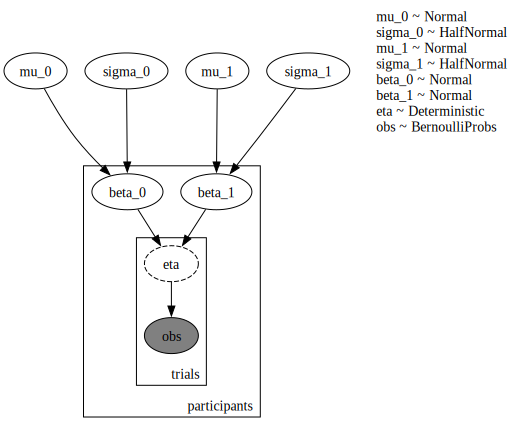

In [124]:
"""
numpyro.render_model(glm, render_distributions=True, render_params=True, model_args=(
    jnp.asarray(df['target_present'].values).astype(int),
    jnp.asarray(df['response_yes'].values).astype(int)
))
"""

numpyro.render_model(glmm, render_distributions=True, render_params=True, model_args=(
    jnp.asarray(reshape_data(df, 'participant_code', dims=['participant'])).astype(int),
    jnp.asarray(reshape_data(df, 'target_present', dims=['participant']).astype(float)),
    jnp.asarray(reshape_data(df, 'response_yes', dims=['participant']).astype(float)),
))

## Extend GLMM with Experiment Parameters

In [ ]:
def extended_glmm(
    participant_code : jnp.ndarray,
    target_present : jnp.ndarray, 
    distance_setting : jnp.ndarray,
    number_of_objects : jnp.ndarray,
    response_yes : Optional[jnp.ndarray] = None
) -> None:
    """
    Fits an equal variance gaussian SDT model based on a probit GLM to the data.
    For discussion, see DeCarlo (1998).

    Parameters:
        participant_code : jnp.ndarray
            For each trial, the code of the participant.
        target_present : jnp.ndarray
            For each trial, whether the trial contained a target.
            Each value can be 0 or 1.
        distance_setting : jnp.ndarray
            For each trial, the distance setting that the trial was parametrized with.
            The distance setting has to be remapped to numerical values:
                {high : 1, mid : 2, low : 3}
        number_of_objects : jnp.ndarray
            For each trial, the number of objects that were on display.
            The number of objects has to be remapped to numerical values:
                {2 : 1, 3 : 2, 4 : 3, 8 : 4, 16 : 5}
        response_yes : jnp.ndarray
            For each trial, whether the participant responded yes on the yes-no task.
            Each value can be 0 or 1.
    
    Returns:
        None
    """
    # global parameters
    mu_d = mu_n = mu_i = 0
    sigma_d = sigma_n = sigma_i = 5

    n_distance_setting  = jnp.unique(distance_setting,  size=3).size
    n_number_of_objects = jnp.unique(number_of_objects, size=5).size
    n_participants = jnp.unique(participant_code, size=10).size

    # distance setting coefficients and intercepts for beta_0 and beta_1
    with numpyro.plate('distance_setting', n_distance_setting):
        # coefficients
        d_0 = numpyro.sample('d_0', dist.Normal(mu_d, sigma_d))
        d_1 = numpyro.sample('d_1', dist.Normal(mu_d, sigma_d))

        # intercepts
        id_0 = numpyro.sample('id_0', dist.Normal(mu_i, sigma_i))
        id_1 = numpyro.sample('id_1', dist.Normal(mu_i, sigma_i))

    # number of objects coefficients and intercepts for beta_0 and beta_1
    with numpyro.plate('number_of_objects', n_number_of_objects):
        # coefficients
        n_0 = numpyro.sample('n_0', dist.Normal(mu_n, sigma_n))
        n_1 = numpyro.sample('n_1', dist.Normal(mu_n, sigma_n))

        # intercepts
        in_0 = numpyro.sample('in_0', dist.Normal(mu_i, sigma_i))
        in_1 = numpyro.sample('in_1', dist.Normal(mu_i, sigma_i))

    # participants coefficients
    with numpyro.plate('participant', n_participants):
        p_0 = numpyro.sample('p_0', dist.Normal(0, 5))
        p_1 = numpyro.sample('p_1', dist.Normal(0, 5))

    # intercept aka criterion
    beta_0 = numpyro.deterministic('beta_0', value=p_0[participant_code] * (id_0[distance_setting] + d_0[distance_setting] * distance_setting + in_0[number_of_objects] + n_0[number_of_objects] * number_of_objects))

    # slope aka d'
    beta_1 = numpyro.deterministic('beta_1', value=p_1[participant_code] * (id_1[distance_setting] + d_1[distance_setting] * distance_setting + in_1[number_of_objects] + n_1[number_of_objects] * number_of_objects))
    
    with numpyro.plate(name='data', size=target_present.size):
        # linear predictor
        eta = numpyro.deterministic(name='eta', value=beta_0 + beta_1 * target_present)

        # probit link
        p = dist.Normal().cdf(eta)
        
        numpyro.sample('obs', dist.Bernoulli(probs=p), obs=response_yes)

In [ ]:
def get_extended_glmm_summary():
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    # Run NUTS.
    kernel = NUTS(extended_glmm)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
    mcmc.run(
        rng_key_,
        participant_code=jnp.asarray(df['participant_code'].values).astype(int),
        target_present=jnp.asarray(df['target_present'].values).astype(int),
        distance_setting=jnp.asarray(df['distance_setting_code'].values).astype(int),
        number_of_objects=jnp.asarray(df['number_of_objects_code'].values).astype(int),
        response_yes=jnp.asarray(df['response_yes'].values).astype(int)
    )
    mcmc.print_summary()
    return numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))

In [ ]:
new_s = get_extended_glmm_summary()

ValueError: Incompatible shapes for broadcasting: shapes=[(14800,), (14800, 3)]

In [ ]:
extended_model_summary = get_extended_glmm_summary()

sample: 100%|██████████| 3000/3000 [32:44<00:00,  1.53it/s, 1023 steps of size 1.31e-04. acc. prob=0.81]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    d_0[0]     -0.21      0.00     -0.21     -0.21     -0.20      4.27      1.45
    d_0[1]      0.97      0.00      0.97      0.97      0.98      7.62      1.00
    d_0[2]     -0.23      0.00     -0.23     -0.24     -0.23      3.79      1.54
    d_1[0]      1.96      0.01      1.96      1.95      1.97      7.75      1.55
    d_1[1]      1.74      0.02      1.74      1.71      1.78      3.39      1.72
    d_1[2]      0.24      0.01      0.24      0.22      0.26      5.25      1.77
   id_0[0]     -1.45      0.00     -1.45     -1.46     -1.45      9.85      1.12
   id_0[1]      0.03      0.00      0.03      0.02      0.04      3.45      1.76
   id_0[2]      1.52      0.01      1.52      1.51      1.52      3.29      1.91
   id_1[0]      0.60      0.00      0.60      0.59      0.61      4.15      1.69
   id_1[1]      0.26      0.01      0.26      0.25      0.28      2.74      2.30
   id_1[2]      0.90      0

In [ ]:
for key in extended_model_summary.keys():
    print(key, extended_model_summary[key]['mean'].shape)

beta_0 (14800,)
beta_1 (14800,)
d_0 (3,)
d_1 (3,)
eta (14800,)
id_0 (3,)
id_1 (3,)
in_0 (5,)
in_1 (5,)
n_0 (5,)
n_1 (5,)
p_0 (10,)
p_1 (10,)


In [ ]:
extended_model_summary['p_0']['mean'][0] * (extended_model_summary['id_0']['mean'][0] + extended_model_summary['d_0']['mean'][0] * (0 + 1) + extended_model_summary['in_0']['mean'][0] + extended_model_summary['n_0']['mean'][0] * (0 + 1))

-0.043594729437804736

In [ ]:
# p_0[participant_code] * (id_0[distance_setting] + d_0[distance_setting] * distance_setting + in_0[number_of_objects] + n_0[number_of_objects] * number_of_objects)
for di, d in enumerate(['high', 'mid', 'low']):
    coeff_d = extended_model_summary['d_0']['mean'][di]
    inter_d = extended_model_summary['id_0']['mean'][di]
    for ni, n in enumerate([2, 3, 4, 8, 16]):
        coeff_n = extended_model_summary['n_0']['mean'][ni]
        inter_n = extended_model_summary['in_0']['mean'][ni]
        print(d, n, inter_d + coeff_d * (di + 1) + inter_n + coeff_n * (ni + 1))

high 2 0.6337795108556747
high 3 -4.250958047807217
high 4 -2.694205865263939
high 8 -3.7119195610284805
high 16 -3.2399268597364426
mid 2 4.274577429518104
mid 3 -0.6101601291447878
mid 4 0.94659205339849
mid 8 -0.07112164236605167
mid 16 0.4008710589259863
low 2 3.1119315773248672
low 3 -1.7728059813380241
low 4 -0.2160537987947464
low 8 -1.233767494559288
low 16 -0.7617747932672501
